### 评分卡

* 建立逻辑回归模型
* 对模型进行评分映射


### 逻辑回归表达式

$$
   y = \frac{1}{1 + e^{-\theta}}
$$

$$
    \theta = WX + B
$$

### sigmoid函数

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

### sigmoid函数的导数

$$
\delta sigmoid(x) = \delta{\frac{1}{1 + e^{-x}}} = \delta{\frac{e^{-x}}{(1 + e^{-x})^2}} = \delta{\frac{1}{1 + e^{-x}} * \frac{e^{-x}}{1 + e^{-x}}} = sigmoid(x) * \frac{1 + e^{-x} - 1}{1 + e^{-x}} = sigmoid(x) * (1 - sigmoid(x))
$$

### 损失函数(Cross-entropy, 交叉熵损失函数)

`信息熵:` $-PlogP$(P是概率, 小于1, 取反之后就是正数了), 这个值代表的是信息量, 如果值越大代表对当前情况越不确定, 信息不足. 


$$
   loss = -\sum{{y_t}log{y_p} + (1 - y_t)log{(1 - y_p)}}
$$

$y_t$: 真实的Y值, 需要进行独热编码

$y_p$: 预测的Y值

### 交叉熵求导

$$
   \frac{\delta loss}{\delta Y_p} = -\frac{\delta Y_tlogY_p}{\delta Y_p} = \sum_n^N{-\frac{Y_i}{P_i} + \frac{1 - Y_i}{1 - P_i}}
$$

### 准确率计算

`混淆矩阵`

| T\Pre | Positive | Negative |
| :---: | :---: | :---: |
| Positive | TP | FN |
| Negative | FP | TN |

### 评估指标

`召回率计算`

$$
recall = \frac{TP}{TP + FP}
$$

`精准率计算`

$$
precision = \frac{TP}{TP + FN}
$$

In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math

In [2]:
data = pd.read_csv('Acard.txt')
data.head()

,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [3]:
#看一下月份分布，我们用最后一个月做为跨时间验证集合
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

In [4]:
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

In [5]:
#这是我们全部的变量，info结尾的是自己做的无监督系统输出的个人表现，score结尾的是收费的外部征信数据
feature_lst = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']

In [6]:
x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

lr_model = LogisticRegression(C=0.1)
lr_model.fit(x,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### 模型评价
- KS值
- ROC曲线

描绘的是不同的截断点时，并以FPR和TPR为横纵坐标轴，描述随着截断点的变小，TPR随着FPR的变化。   
纵轴：TPR=正例分对的概率 = TP/(TP+FN)，其实就是查全率   
横轴：FPR=负例分错的概率 = FP/(FP+TN)

作图步骤：

根据学习器的预测结果（注意，是正例的概率值，非0/1变量）对样本进行排序（从大到小）-----这就是截断点依次选取的顺序
按顺序选取截断点，并计算TPR和FPR---也可以只选取n个截断点，分别在1/n，2/n，3/n等位置
连接所有的点（TPR，FPR）即为ROC图  

#### KS值

作图步骤：

根据学习器的预测结果（注意，是正例的概率值，非0/1变量）对样本进行排序（从大到小）-----这就是截断点依次选取的顺序  
按顺序选取截断点，并计算TPR和FPR ---也可以只选取n个截断点，分别在1/n，2/n，3/n等位置  
横轴为样本的占比百分比（最大100%），纵轴分别为TPR和FPR，可以得到KS曲线  
TPR和FPR曲线分隔最开的位置就是最好的”截断点“，最大间隔距离就是KS值，通常>0.2即可认为模型有比较好偶的预测准确性  

train_ks :  0.4482453222991063
val_ks :  0.4198642457760936


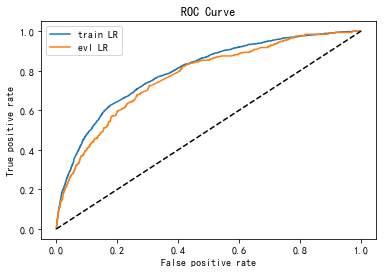

In [17]:
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [9]:
#再做特征筛选
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = np.array(x)
for i in range(X.shape[1]):
    print(variance_inflation_factor(X,i))

1.3021397545577784
1.9579535743187186
1.2899442089163675
2.968170867332405
3.287109972276014
3.286493284008914
3.317508798033784
3.2910065791107597


In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=0,test_size=0.2)
def  lgb_test(train_x,train_y,test_x,test_y):
    clf =lgb.LGBMClassifier(boosting_type = 'gbdt',
                           objective = 'binary',
                           metric = 'auc',
                           learning_rate = 0.1,
                           n_estimators = 24,
                           max_depth = 5,
                           num_leaves = 20,
                           max_bin = 45,
                           min_data_in_leaf = 6,
                           bagging_fraction = 0.6,
                           bagging_freq = 0,
                           feature_fraction = 0.8,
                           )
    clf.fit(train_x,train_y,eval_set = [(train_x,train_y),(test_x,test_y)],eval_metric = 'auc')
    return clf,clf.best_score_['valid_1']['auc'],
lgb_model , lgb_auc  = lgb_test(train_x,train_y,test_x,test_y)
feature_importance = pd.DataFrame({'name':lgb_model.booster_.feature_name(),
                                   'importance':lgb_model.feature_importances_}).sort_values(by=['importance'],ascending=False)
feature_importance

[1]	training's auc: 0.759467	valid_1's auc: 0.753322
[2]	training's auc: 0.809023	valid_1's auc: 0.805658
[3]	training's auc: 0.809328	valid_1's auc: 0.803858
[4]	training's auc: 0.810298	valid_1's auc: 0.801355
[5]	training's auc: 0.814873	valid_1's auc: 0.807356
[6]	training's auc: 0.816492	valid_1's auc: 0.809279
[7]	training's auc: 0.820213	valid_1's auc: 0.809208
[8]	training's auc: 0.823931	valid_1's auc: 0.812081
[9]	training's auc: 0.82696	valid_1's auc: 0.81453
[10]	training's auc: 0.827882	valid_1's auc: 0.813428
[11]	training's auc: 0.828881	valid_1's auc: 0.814226
[12]	training's auc: 0.829577	valid_1's auc: 0.813749
[13]	training's auc: 0.830406	valid_1's auc: 0.813156
[14]	training's auc: 0.830843	valid_1's auc: 0.812973
[15]	training's auc: 0.831587	valid_1's auc: 0.813501
[16]	training's auc: 0.831898	valid_1's auc: 0.813611
[17]	training's auc: 0.833751	valid_1's auc: 0.81393
[18]	training's auc: 0.834139	valid_1's auc: 0.814532
[19]	training's auc: 0.835177	valid_1's 

,name,importance
2,credit_info,98
3,act_info,62
4,td_score,54
5,jxl_score,50
7,rh_score,50
0,person_info,49
1,finance_info,47
6,mj_score,46


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train_ks :  0.4482453222991063
val_ks :  0.4198642457760936


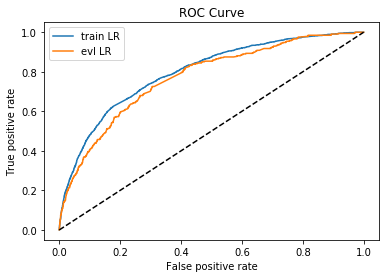

In [11]:
feature_lst = ['person_info','finance_info','credit_info','act_info']
x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [12]:
# 系数
print('变量名单：',feature_lst)
print('系数：',lr_model.coef_)
print('截距：',lr_model.intercept_)

变量名单： ['person_info', 'finance_info', 'credit_info', 'act_info']
系数： [[ 3.49460978 11.40051582  2.45541981 -1.68676079]]
截距： [-0.34484897]


In [13]:
#生成报告
model = lr_model
row_num, col_num = 0, 0
bins = 20
Y_predict = [s[1] for s in model.predict_proba(val_x)]
Y = val_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
bin_num = int(nrows/bins+1)
bad = sum([1 for (p, y) in ks_lis if y > 0.5])
good = sum([1 for (p, y) in ks_lis if y <= 0.5])
bad_cnt, good_cnt = 0, 0
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}
for j in range(bins):
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]
    bad1 = sum([1 for (p, y) in ds if y > 0.5])
    good1 = sum([1 for (p, y) in ds if y <= 0.5])
    bad_cnt += bad1
    good_cnt += good1
    bad_pctg = round(bad_cnt/sum(val_y),3)
    badrate = round(bad1/(bad1+good1),3)
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3)
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_repot = pd.DataFrame(dct_report)
val_repot

,KS,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE
0,0.217,86,713,86,713,0.262,0.108
1,0.299,43,756,129,1469,0.393,0.054
2,0.339,29,770,158,2239,0.482,0.036
3,0.381,30,769,188,3008,0.573,0.038
4,0.398,22,777,210,3785,0.640,0.028
5,0.403,18,781,228,4566,0.695,0.023
6,0.408,18,781,246,5347,0.750,0.023
7,0.398,13,786,259,6133,0.790,0.016
8,0.396,16,783,275,6916,0.838,0.020
9,0.361,5,794,280,7710,0.854,0.006


In [14]:
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "分组坏人占比",
        list(val_repot.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "KS",
        list(val_repot['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()

In [15]:
#['person_info','finance_info','credit_info','act_info']
#算分数onekey 
def score(person_info,finance_info,credit_info,act_info):
    xbeta = person_info * ( 3.49460978) + finance_info * ( 11.40051582 ) + credit_info * (2.45541981) + act_info * ( -1.68676079) --0.34484897 
    score = 650-34* (xbeta)/math.log(2)
    return score
val['score'] = val.apply(lambda x : score(x.person_info,x.finance_info,x.credit_info,x.act_info) ,axis=1)

fpr_lr,tpr_lr,_ = roc_curve(val_y,val['score'])
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

#对应评级区间
def level(score):
    level = 0
    if score <= 600:
        level = "D"
    elif score <= 640 and score > 600 : 
        level = "C"
    elif score <= 680 and score > 640:
        level = "B"
    elif  score > 680 :
        level = "A"
    return level
val['level'] = val.score.map(lambda x : level(x) )

val.level.groupby(val.level).count()/len(val)

val_ks :  0.4198642457760936


level
A    0.144351
B    0.240188
C    0.391299
D    0.224163
Name: level, dtype: float64

level
A    0.002168
B    0.008079
C    0.014878
D    0.055571
Name: bad_ind, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


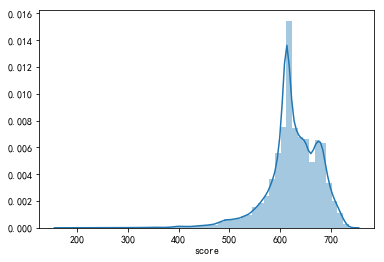

In [16]:
import seaborn as sns
sns.distplot(val.score,kde=True)

val = val.sort_values('score',ascending=True).reset_index(drop=True)
df2=val.bad_ind.groupby(val['level']).sum()
df3=val.bad_ind.groupby(val['level']).count()
print(df2/df3)    